# `MonotonicSplineEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasis` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import cProfile
import math
import pstats
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 18  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 400 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 18 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTA


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

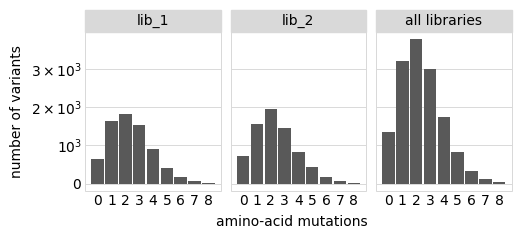

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

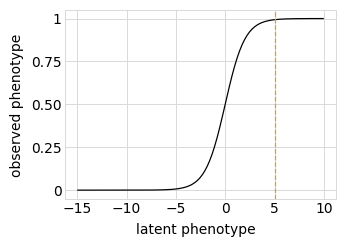

In [10]:
p = phenosimulator.plotLatentVsObserved()
_ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

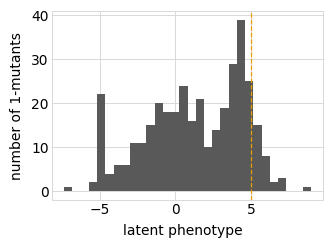

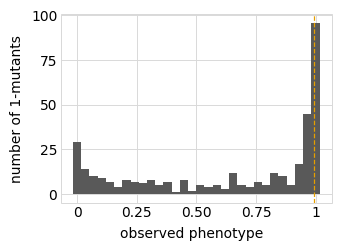

In [11]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedPhenotype,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

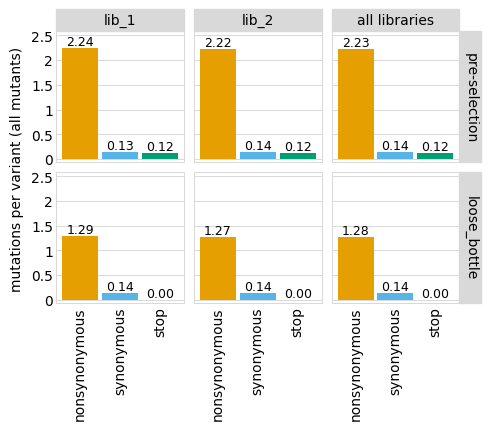

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,16163111,7200000,2.244877
1,lib_1,pre-selection,synonymous,942578,7200000,0.130914
2,lib_1,pre-selection,stop,860729,7200000,0.119546
3,lib_1,loose_bottle,nonsynonymous,9255090,7200000,1.285429
4,lib_1,loose_bottle,synonymous,985042,7200000,0.136811
5,lib_1,loose_bottle,stop,3739,7200000,0.000519
6,lib_2,pre-selection,nonsynonymous,15965422,7200000,2.217420
7,lib_2,pre-selection,synonymous,1030620,7200000,0.143142
8,lib_2,pre-selection,stop,873779,7200000,0.121358
9,lib_2,loose_bottle,nonsynonymous,9125429,7200000,1.267421


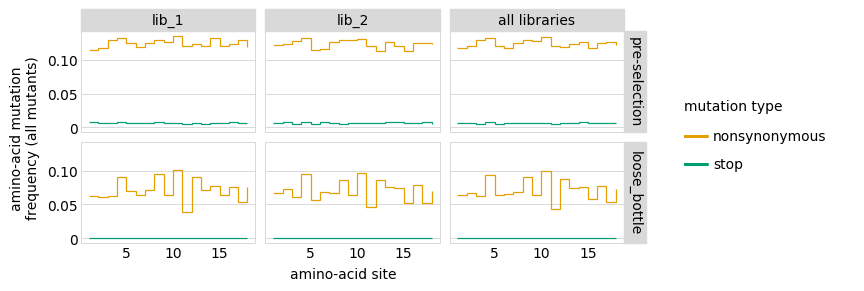

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

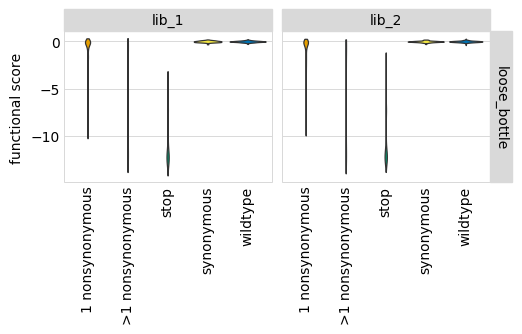

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize `MonotonicSplineEpistasis` model

Focus just on loose bottleneck for now:

In [20]:
func_scores = func_scores.query('post_sample == "loose_bottle"')

Make a binary map for the variants:

In [21]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 360


Now initialize the model:

In [22]:
spline_model = dms_variants.globalepistasis.MonotonicSplineEpistasis(binarymap)

Look at some model attributes:

In [23]:
spline_model.nparams

368

In [24]:
spline_model.epistasis_HOC

1.0

In [25]:
round(spline_model.loglik)

-772002.0

In [26]:
spline_model.latent_phenotype_wt

0.0

In [27]:
for key, val in spline_model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -14.19
alpha_1: 2.91
alpha_2: 2.91
alpha_3: 2.91
alpha_4: 2.91
alpha_5: 2.91


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [28]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Fit model
Perform initial least squares optimization followed by rescaling latent effects (normally this is actually performed by the `fit` method):

In [29]:
spline_model._fit_latent_leastsquares()
spline_model._prescale_params()

Re-check the gradients:

In [30]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Print model parameters after this "partial" fitting:

In [31]:
round(spline_model.loglik)

-40630.0

In [32]:
round(spline_model.epistasis_HOC, 3)

2.898

In [33]:
round(spline_model.latent_phenotype_wt, 3)

0.93

Now fit the model by maximum likelihood, also profiling [as here](https://stackoverflow.com/a/1584468):

In [34]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
profiler = cProfile.Profile()
optres = profiler.runcall(spline_model.fit)
print(f"Fitting took {time.time() - start:.3f}")
print(f"Optimization took {optres.nfev} function evaluations and {optres.nit} iterations")

Fitting took 64.202
Optimization took 1837 function evaluations and 1610 iterations


Look at some of the model parameters after optimization:

In [35]:
round(spline_model.loglik)

-516.0

In [36]:
round(spline_model.epistasis_HOC, 3)

0.004

In [37]:
round(spline_model.latent_phenotype_wt, 3)

0.0

In [38]:
spline_model._mesh.round(3)

array([-7.98 , -5.555, -3.13 , -0.706])

In [39]:
spline_model.alpha_ms.round(3)

array([ 0.   ,  0.   ,  0.   , 12.693,  0.02 ])

In [40]:
round(spline_model.c_alpha, 2)

-12.75

Plot correlation of actual functional scores with latent and observed phenotypes:


Correlation for latent:
R = 0.912, P = 0

Correlation for observed:
R = 0.994, P = 0


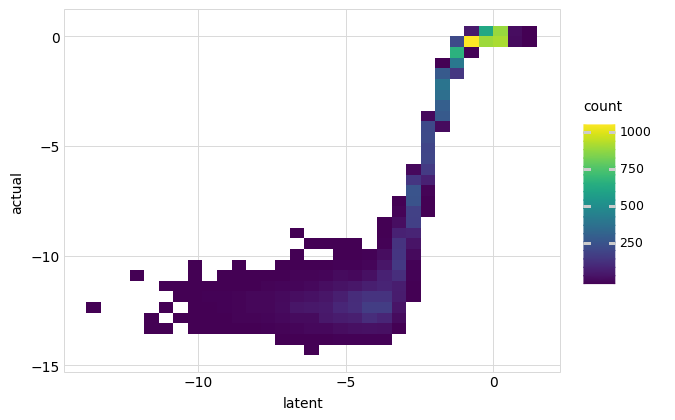

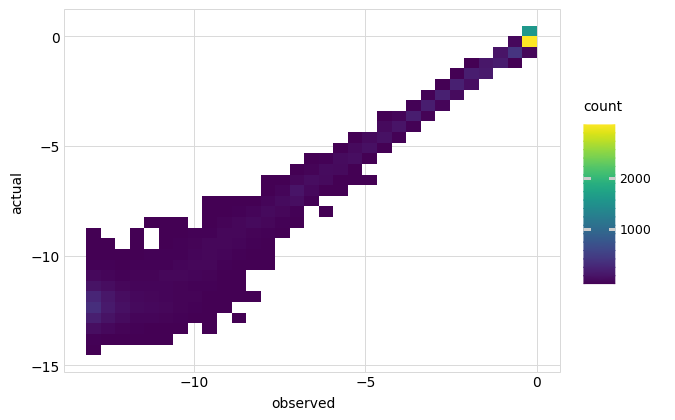

In [41]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'latent': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'latent'),
                   'observed': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'observed'),
                   })

for phenotype in ['latent', 'observed']:
    r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        spline_model.phenotypes_frombinary(binarymap.binary_variants, phenotype)
        )
    print(f"\nCorrelation for {phenotype}:\nR = {r:.3f}, P = {p:.2g}")

    _ = (ggplot(df, aes(phenotype, 'actual')) +
         geom_bin2d()
         ).draw()

Plot latent versus observed phenotypes:

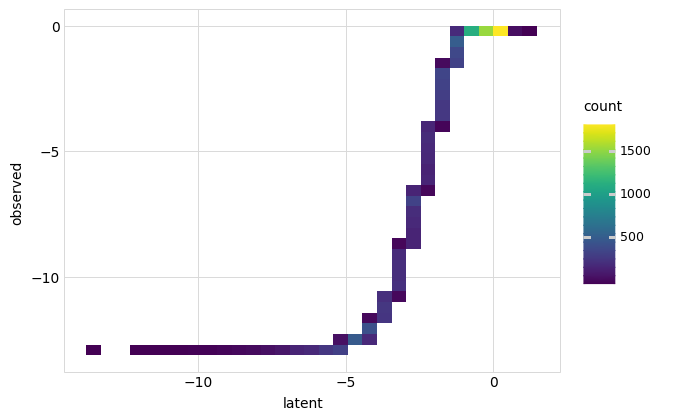

In [42]:
_ = (ggplot(df, aes('latent', 'observed')) +
     geom_bin2d()
     ).draw()

Look at profiling results:

In [43]:
# NBVAL_IGNORE_OUTPUT
with tempfile.NamedTemporaryFile('w') as f:
    profiler.dump_stats(f.name)
    f.flush()
    stats = pstats.Stats(f.name).strip_dirs()
for stat in ['cumtime', 'tottime']:
    print(stats.sort_stats(stat).print_stats(20))

Fri Oct 25 21:35:04 2019    /tmp/tmp71yu698t

         17198096 function calls (15487588 primitive calls) in 64.202 seconds

   Ordered by: cumulative time
   List reduced from 341 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   64.202   64.202 globalepistasis.py:512(fit)
        1    0.000    0.000   64.124   64.124 _minimize.py:42(minimize)
        1    0.212    0.212   64.124   64.124 lbfgsb.py:211(_minimize_lbfgsb)
     1837    0.011    0.000   63.905    0.035 lbfgsb.py:284(func_and_grad)
881800/5512    1.539    0.000   52.213    0.009 methodtools.py:31(__call__)
     5512    1.465    0.000   52.180    0.009 ispline.py:247(_calculate_Itotal_or_dItotal)
    36745    3.160    0.000   47.120    0.001 ispline.py:673(_calculate_I_or_dI)
     1837    0.005    0.000   38.481    0.021 optimize.py:324(function_wrapper)
     1837    0.005    0.000   38.476    0.021 globalepistasis.py:560(_loglik_by_allparams